# Grocery Sales Forecasting - Simplified EDA & Feature Engineering

This notebook performs efficient data cleaning, merging, feature engineering, and exploratory data analysis for predicting 1-16 days ahead of unit_sales.

**Goal:** Prepare data for Item-Store Daily Forecasting model

**Optimized Strategy (Memory Efficient):** 
- Load and merge datasets efficiently
- Create ESSENTIAL features only (~18 features vs 30+)
- Work on full dataset without redundant saves
- Sample for visualizations only
- Final train/test split

**Contents:**
1. Data Loading & Cleaning
2. Dataset Merging (in-place, no intermediate saves)
3. Feature Engineering - Essential Features Only
4. Stratified Sampling for Visualizations
5. 10 Essential Visualizations
6. Train/Test Split & Save

## 1. Import Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.2.5


In [12]:
import pandas as pd
import pyarrow.parquet as pq

pq.read_metadata("raw_data/df_train_all_v1.parquet")


  created_by: parquet-cpp-arrow version 8.0.0
  num_columns: 5
  num_rows: 125497040
  num_row_groups: 2
  format_version: 1.0
  serialized_size: 3996

## 2. Data Loading & Initial Cleaning

In [19]:
# Load all datasets
print("Loading datasets...")
#try: 
df_train = pd.read_parquet('df_train_all_v1.parquet', engine='pyarrow')
#except Exception as e:
#    print(f"PyArrow failed: {e}")
 #   print("Trying fastparquet engine...")
  #  df_train = pd.read_parquet('raw_data/df_train_all_v1.parquet', engine='fastparquet')
df_items = pd.read_parquet('raw_data/items.parquet')
df_stores = pd.read_parquet('raw_data/stores.parquet')
df_oil = pd.read_parquet('raw_data/oil.parquet')
df_transactions = pd.read_parquet('raw_data/transactions.parquet')
df_holidays = pd.read_parquet('raw_data/holiday_events.parquet')

print(f"✓ Train data: {df_train.shape}")
print(f"✓ Items: {df_items.shape}")
print(f"✓ Stores: {df_stores.shape}")
print(f"✓ Oil: {df_oil.shape}")
print(f"✓ Transactions: {df_transactions.shape}")
print(f"✓ Holidays: {df_holidays.shape}")

# Display sample data
print("\n" + "="*50)
print("SAMPLE DATA:")
print("="*50)
print("\nTrain data:")
print(df_train.head(3))
print("\nItems:")
print(df_items.head(3))
print("\nStores:")
print(df_stores.head(3))

Loading datasets...
✓ Train data: (125497040, 5)
✓ Items: (4100, 3)
✓ Stores: (54, 4)
✓ Oil: (1218, 2)
✓ Transactions: (83488, 3)
✓ Holidays: (350, 6)

SAMPLE DATA:

Train data:
        date  store_nbr  item_nbr  unit_sales  onpromotion
0 2013-01-01         25    103665    2.079442        False
1 2013-01-01         25    105574    0.693147        False
2 2013-01-01         25    105575    1.098612        False

Items:
             family  class  perishable
item_nbr                              
96995     GROCERY I   1093           0
99197     GROCERY I   1067           0
103501     CLEANING   3008           0

Stores:
            city      state type  cluster
store_nbr                                
1          Quito  Pichincha    D       13
2          Quito  Pichincha    D       13
3          Quito  Pichincha    D        8


### 2.1 Convert Date Columns to Datetime

In [20]:
print("Converting date columns to datetime...")

# Convert date columns
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

print("✓ All date columns converted to datetime")
print(f"\nDate ranges:")
print(f"Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"Oil: {df_oil['date'].min()} to {df_oil['date'].max()}")
print(f"Transactions: {df_transactions['date'].min()} to {df_transactions['date'].max()}")
print(f"Holidays: {df_holidays['date'].min()} to {df_holidays['date'].max()}")

Converting date columns to datetime...
✓ All date columns converted to datetime

Date ranges:
Train: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Oil: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Transactions: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Holidays: 2012-03-02 00:00:00 to 2017-12-26 00:00:00


### 2.2 Interpolate Missing Oil Prices (43 values)

In [21]:
print("Handling missing oil prices...")
print(f"Missing oil prices before: {df_oil['dcoilwtico'].isna().sum()}")

# Linear interpolation
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

# Forward fill for any remaining
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')

# Backward fill for any at the beginning
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

print(f"Missing oil prices after: {df_oil['dcoilwtico'].isna().sum()}")
print("✓ Oil prices interpolated successfully")

Handling missing oil prices...
Missing oil prices before: 43
Missing oil prices after: 0
✓ Oil prices interpolated successfully


## 3. Dataset Merging (Sequential Order)

In [22]:
print("Merging datasets in order...")
print(f"Starting with train data: {df_train.shape}")

# Step 1: Merge items
df = df_train.merge(df_items, on='item_nbr', how='left')
print(f"After merging items: {df.shape}")

# Step 2: Merge stores
df = df.merge(df_stores, on='store_nbr', how='left')
print(f"After merging stores: {df.shape}")

# Step 3: Merge oil
df = df.merge(df_oil, on='date', how='left')
print(f"After merging oil: {df.shape}")

# Step 4: Merge transactions
df = df.merge(df_transactions, on=['date', 'store_nbr'], how='left')
print(f"After merging transactions: {df.shape}")

# Step 5: Merge holidays - create holiday flags
df_holidays_clean = df_holidays.copy()
df_holidays_clean['is_holiday'] = 1
# Keep only necessary columns from holidays
holidays_agg = df_holidays_clean.groupby('date').agg({
    'is_holiday': 'max',
    'type': lambda x: ', '.join(x.unique()),
    'transferred': 'max'
}).reset_index()
holidays_agg.columns = ['date', 'is_holiday', 'holiday_type', 'holiday_transferred']

df = df.merge(holidays_agg, on='date', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)
print(f"After merging holidays: {df.shape}")

print(f"\n✓ Final merged dataset: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Merging datasets in order...
Starting with train data: (125497040, 5)
After merging items: (125497040, 8)
After merging stores: (125497040, 12)
After merging oil: (125497040, 13)
After merging transactions: (125497040, 14)
After merging holidays: (125497040, 17)

✓ Final merged dataset: (125497040, 17)

Columns: ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family', 'class', 'perishable', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'transactions', 'is_holiday', 'holiday_type', 'holiday_transferred']


## 4. Feature Engineering - Essential Features Only (~18 Features)

**Memory Optimized:** Only creating features that add real predictive value. Removed memory-intensive aggregate and expanding window features.

In [23]:
print("Adding year column for feature engineering...")

# Add year column (needed for temporal features)
df['year'] = df['date'].dt.year

print(f"✓ Year column added")
print(f"✓ Working with FULL dataset: {df.shape}")

Adding year column for feature engineering...
✓ Year column added
✓ Working with FULL dataset: (125497040, 18)


### 4.1 Temporal Features (8 features)

In [24]:
print("Creating temporal features...")

# Temporal features
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

temporal_features = ['year', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 
                     'is_weekend', 'is_month_start', 'is_month_end']

print(f"✓ Created {len(temporal_features)} temporal features")
print(f"Features: {temporal_features}")

Creating temporal features...
✓ Created 8 temporal features
Features: ['year', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end']


### 4.2 Lag Features (4 features)
Creating lags grouped by (store_nbr, item_nbr) to prevent data leakage.

In [25]:
print("Creating lag features (grouped by store_nbr, item_nbr)...")

# Sort by store, item, and date
df = df.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

# Create lag features
df['sales_lag_1'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df['sales_lag_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
df['sales_lag_14'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(14)
df['sales_lag_28'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(28)

lag_features = ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28']

print(f"✓ Created {len(lag_features)} lag features")
print(f"Features: {lag_features}")
print(f"Missing values in lag_1 (expected for first days): {df['sales_lag_1'].isna().sum():,}")

Creating lag features (grouped by store_nbr, item_nbr)...
✓ Created 4 lag features
Features: ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28']
Missing values in lag_1 (expected for first days): 174,685


### 4.3 Rolling Statistics (6 features)
Creating rolling windows grouped by (store_nbr, item_nbr).

In [26]:
print("Creating rolling statistics features...")

# Rolling windows (using shift to prevent data leakage)
df['rolling_mean_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)
df['rolling_mean_14'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=14, min_periods=1).mean()
)
df['rolling_mean_28'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=28, min_periods=1).mean()
)
df['rolling_std_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).std()
)
df['rolling_max_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).max()
)
df['rolling_min_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).min()
)

rolling_features = ['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 
                    'rolling_std_7', 'rolling_max_7', 'rolling_min_7']

print(f"✓ Created {len(rolling_features)} rolling features")
print(f"Features: {rolling_features}")

Creating rolling statistics features...
✓ Created 6 rolling features
Features: ['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7']


### 4.4 Holiday Features (3 features)

In [27]:
print("Creating holiday features...")

# Simple holiday feature - just use is_before_holiday (3 days before)
df['is_before_holiday'] = 0
holiday_dates = df[df['is_holiday'] == 1]['date'].unique()

# Vectorized approach - much faster than apply
for holiday_date in holiday_dates:
    mask = (df['date'] >= holiday_date - pd.Timedelta(days=3)) & (df['date'] < holiday_date)
    df.loc[mask, 'is_before_holiday'] = 1

holiday_features = ['is_holiday', 'is_before_holiday']

print(f"✓ Created {len(holiday_features)} holiday features")
print(f"Features: {holiday_features}")
print(f"Total holidays: {df['is_holiday'].sum():,}")
print(f"Days before holidays: {df['is_before_holiday'].sum():,}")

Creating holiday features...
✓ Created 2 holiday features
Features: ['is_holiday', 'is_before_holiday']
Total holidays: 19,354,991
Days before holidays: 38,695,483


### 4.5 Promotion Features (3 features)

In [28]:
print("Creating promotion features...")

# Ensure onpromotion is binary
df['onpromotion'] = df['onpromotion'].fillna(0).astype(int)

# Promo lag (was there a promotion 7 days ago?)
df['promo_lag_7'] = df.groupby(['store_nbr', 'item_nbr'])['onpromotion'].shift(7)

# Promotion frequency in last 30 days
df['promo_frequency_30'] = df.groupby(['store_nbr', 'item_nbr'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(window=30, min_periods=1).sum()
)

promo_features = ['promo_lag_7', 'promo_frequency_30']

print(f"✓ Created {len(promo_features)} promotion features")
print(f"Features: {promo_features}")
print(f"Items on promotion: {df['onpromotion'].sum():,} ({df['onpromotion'].mean()*100:.1f}%)")

Creating promotion features...
✓ Created 2 promotion features
Features: ['promo_lag_7', 'promo_frequency_30']
Items on promotion: 7,810,622 (6.2%)


### 4.6 Interaction Features (3 features)

In [29]:
print("Creating interaction features...")

# Promotion on weekend
df['promo_weekend'] = df['onpromotion'] * df['is_weekend']

# Perishable on weekend
df['perishable_weekend'] = df['perishable'] * df['is_weekend']

# Holiday with promotion
df['holiday_promo'] = df['is_holiday'] * df['onpromotion']

interaction_features = ['promo_weekend', 'perishable_weekend', 'holiday_promo']

print(f"✓ Created {len(interaction_features)} interaction features")
print(f"Features: {interaction_features}")

Creating interaction features...
✓ Created 3 interaction features
Features: ['promo_weekend', 'perishable_weekend', 'holiday_promo']


### 4.7 Feature Engineering Summary

In [30]:
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

all_engineered_features = (temporal_features + lag_features + rolling_features + 
                           holiday_features + promo_features + interaction_features)

print(f"\nTotal engineered features: {len(all_engineered_features)}")
print(f"\nBreakdown:")
print(f"  - Temporal: {len(temporal_features)}")
print(f"  - Lag: {len(lag_features)}")
print(f"  - Rolling: {len(rolling_features)}")
print(f"  - Holiday: {len(holiday_features)}")
print(f"  - Promotion: {len(promo_features)}")
print(f"  - Interaction: {len(interaction_features)}")

print(f"\nFull dataset shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

# Display sample with new features
print("\nSample of engineered features:")
feature_cols = ['date', 'store_nbr', 'item_nbr', 'unit_sales'] + all_engineered_features[:10]
print(df[feature_cols].head())

print("\n✓ Features created in-place - no intermediate saves needed!")
print("✓ Ready to proceed with sampling and visualization")

FEATURE ENGINEERING SUMMARY

Total engineered features: 25

Breakdown:
  - Temporal: 8
  - Lag: 4
  - Rolling: 6
  - Holiday: 2
  - Promotion: 2
  - Interaction: 3

Full dataset shape: (125497040, 41)
Total columns: 41
Memory usage: 68.16 GB

Sample of engineered features:
        date  store_nbr  item_nbr  unit_sales  year  month  day_of_week  \
0 2013-01-10          1     96995    0.693147  2013      1            3   
1 2013-01-11          1     96995    0.693147  2013      1            4   
2 2013-01-14          1     96995    0.693147  2013      1            0   
3 2013-01-18          1     96995    1.098612  2013      1            4   
4 2013-01-21          1     96995    0.693147  2013      1            0   

   day_of_month  week_of_year  is_weekend  is_month_start  is_month_end  \
0            10             2           0               0             0   
1            11             2           0               0             0   
2            14             3           0         

## 5. Create Stratified Sample (2M rows - FOR VISUALIZATIONS ONLY)

In [31]:
print("Creating stratified sample for VISUALIZATIONS ONLY...")
print("(Full dataset preserved in memory for final train/test split)")

# Create stratification key
df['strata'] = df['year'].astype(str) + '_' + df['family'] + '_' + df['type']

# Calculate sample size per stratum
n_sample = 2_000_000
total_rows = len(df)
sample_fraction = n_sample / total_rows

print(f"\nFull dataset: {total_rows:,} rows")
print(f"Sample size: {n_sample:,} rows")
print(f"Sample fraction: {sample_fraction:.4f}")

# Stratified sampling
df_sample = df.groupby('strata', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42) if len(x) > 1 else x
).reset_index(drop=True)

# Drop the strata column from both dataframes to save memory
df = df.drop('strata', axis=1)
df_sample = df_sample.drop('strata', axis=1)

print(f"\n✓ Sample created: {df_sample.shape}")
print(f"\nYears distribution in sample:")
print(df_sample['year'].value_counts().sort_index())
print(f"\nFamilies in sample: {df_sample['family'].nunique()}")
print(f"Store types in sample: {df_sample['type'].nunique()}")

print("\n" + "="*60)
print("⚠️  IMPORTANT: Sample is ONLY for visualizations below")
print("⚠️  Full dataset (df) is preserved in memory for train/test split")
print("="*60)

Creating stratified sample for VISUALIZATIONS ONLY...
(Full dataset preserved in memory for final train/test split)

Full dataset: 125,497,040 rows
Sample size: 2,000,000 rows
Sample fraction: 0.0159

✓ Sample created: (2000011, 41)

Years distribution in sample:
year
2013    260128
2014    354934
2015    444070
2016    561449
2017    379430
Name: count, dtype: int64

Families in sample: 33
Store types in sample: 5

⚠️  IMPORTANT: Sample is ONLY for visualizations below
⚠️  Full dataset (df) is preserved in memory for train/test split


## 6. Exploratory Data Analysis - 10 Essential Visualizations (on 2M sample)

### Visualization 1: Daily Aggregate Sales Trend (2013-2017)

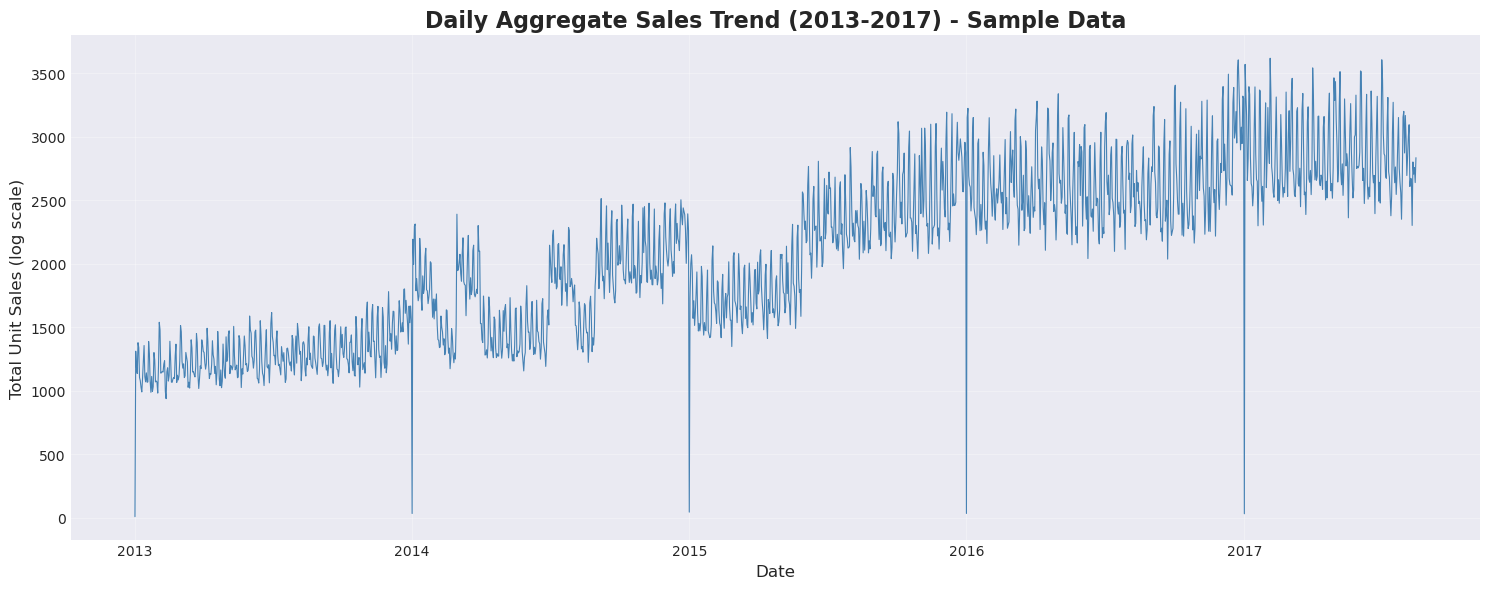

Overall trend: Min=9.13, Max=3619.46, Mean=2079.28


In [32]:
plt.figure(figsize=(15, 6))

daily_sales = df_sample.groupby('date')['unit_sales'].sum().reset_index()
plt.plot(daily_sales['date'], daily_sales['unit_sales'], linewidth=0.8, color='steelblue')
plt.title('Daily Aggregate Sales Trend (2013-2017) - Sample Data', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Unit Sales (log scale)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Overall trend: Min={daily_sales['unit_sales'].min():.2f}, Max={daily_sales['unit_sales'].max():.2f}, Mean={daily_sales['unit_sales'].mean():.2f}")

### Visualization 2: Log Unit Sales Distribution

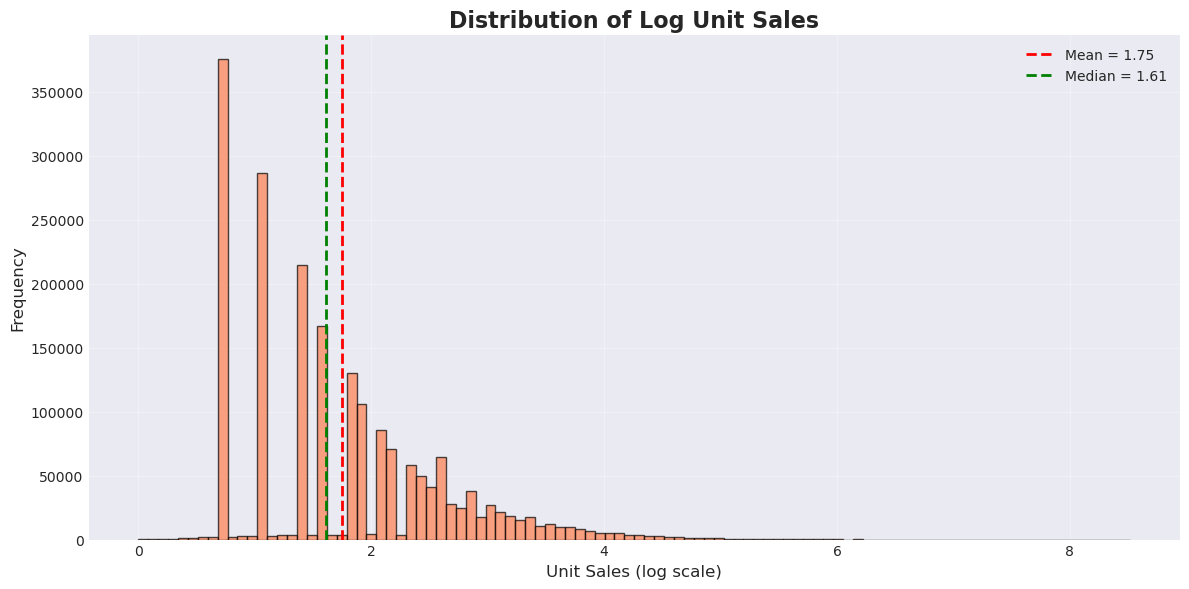

Statistics: Mean=1.75, Median=1.61, Std=0.88


In [33]:
plt.figure(figsize=(12, 6))

plt.hist(df_sample['unit_sales'], bins=100, edgecolor='black', alpha=0.7, color='coral')
plt.title('Distribution of Log Unit Sales', fontsize=16, fontweight='bold')
plt.xlabel('Unit Sales (log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df_sample['unit_sales'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_sample["unit_sales"].mean():.2f}')
plt.axvline(df_sample['unit_sales'].median(), color='green', linestyle='--', linewidth=2, label=f'Median = {df_sample["unit_sales"].median():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Statistics: Mean={df_sample['unit_sales'].mean():.2f}, Median={df_sample['unit_sales'].median():.2f}, Std={df_sample['unit_sales'].std():.2f}")

### Visualization 3: Average Sales by Product Family

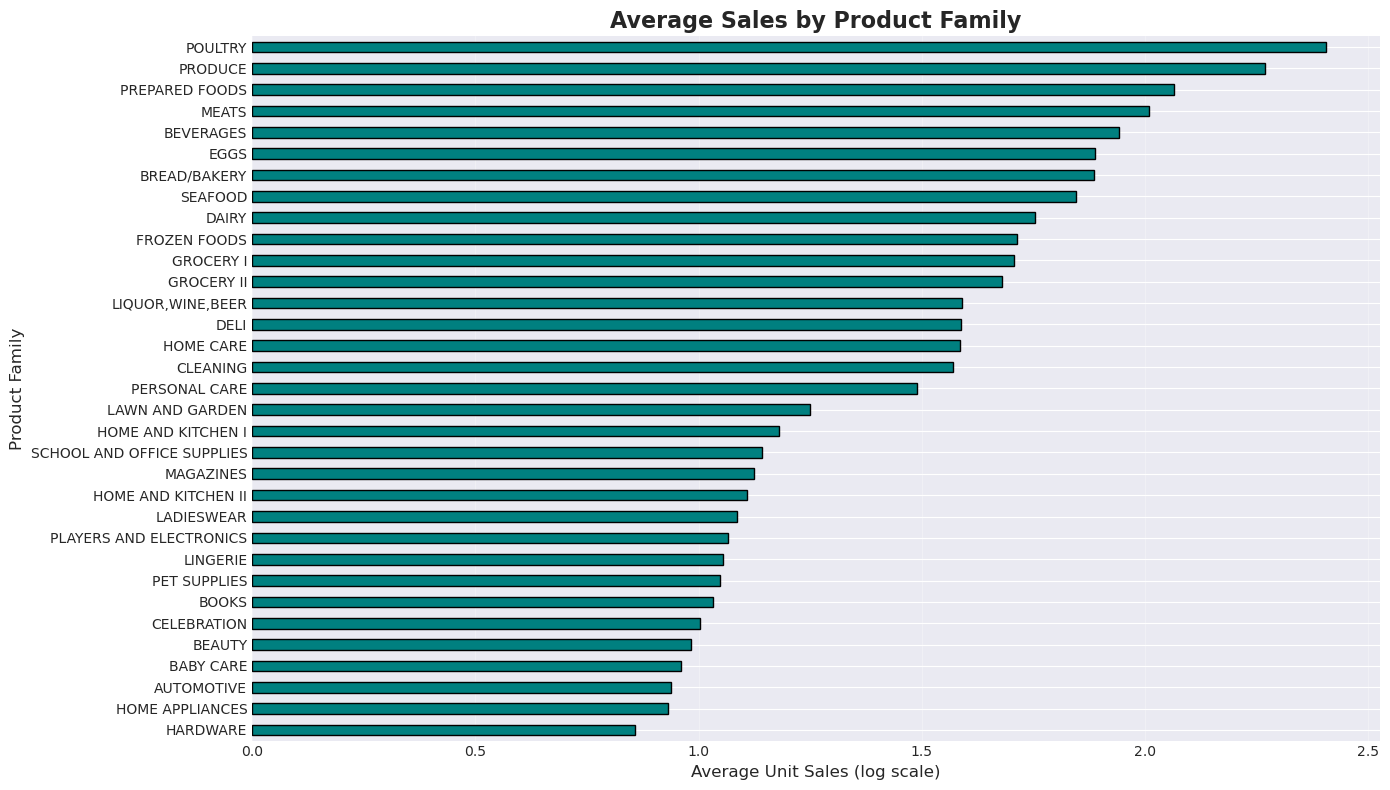

Top 5 families by average sales:
family
BEVERAGES         1.940458
MEATS             2.007808
PREPARED FOODS    2.064037
PRODUCE           2.269051
POULTRY           2.405703
Name: unit_sales, dtype: float64


In [34]:
plt.figure(figsize=(14, 8))

family_sales = df_sample.groupby('family')['unit_sales'].mean().sort_values(ascending=True)
family_sales.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Average Sales by Product Family', fontsize=16, fontweight='bold')
plt.xlabel('Average Unit Sales (log scale)', fontsize=12)
plt.ylabel('Product Family', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"Top 5 families by average sales:")
print(family_sales.tail())

### Visualization 4: Promotion Impact (On vs Off)

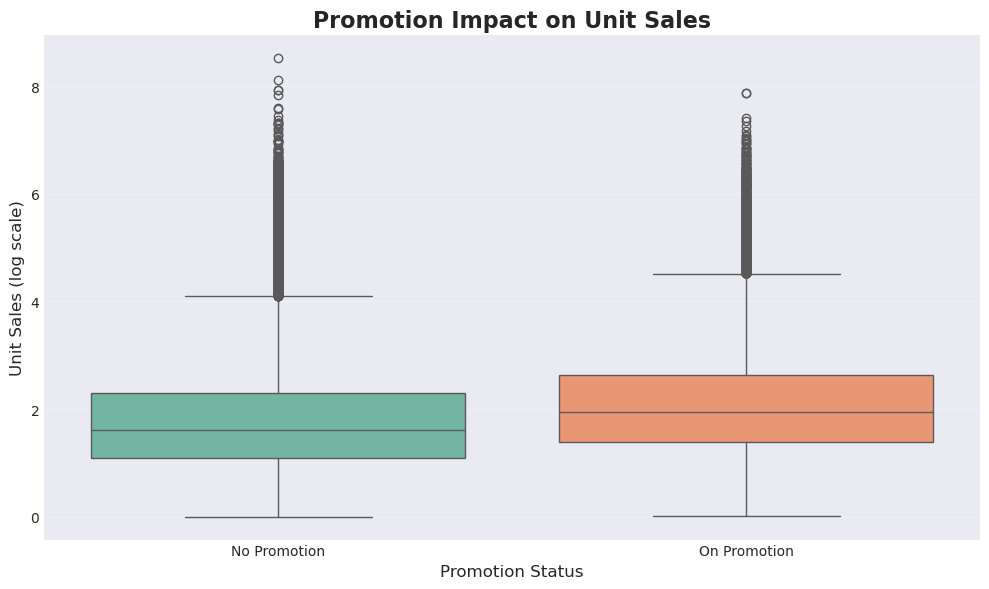


Promotion Statistics:
                 mean    median    count
onpromotion                             
0            1.731593  1.609438  1875612
1            2.039474  1.945910   124399


In [35]:
plt.figure(figsize=(10, 6))

df_sample['promo_status'] = df_sample['onpromotion'].map({0: 'No Promotion', 1: 'On Promotion'})
sns.boxplot(data=df_sample, x='promo_status', y='unit_sales', palette='Set2')
plt.title('Promotion Impact on Unit Sales', fontsize=16, fontweight='bold')
plt.xlabel('Promotion Status', fontsize=12)
plt.ylabel('Unit Sales (log scale)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

promo_stats = df_sample.groupby('onpromotion')['unit_sales'].agg(['mean', 'median', 'count'])
print("\nPromotion Statistics:")
print(promo_stats)

### Visualization 5: Day-of-Week Seasonality

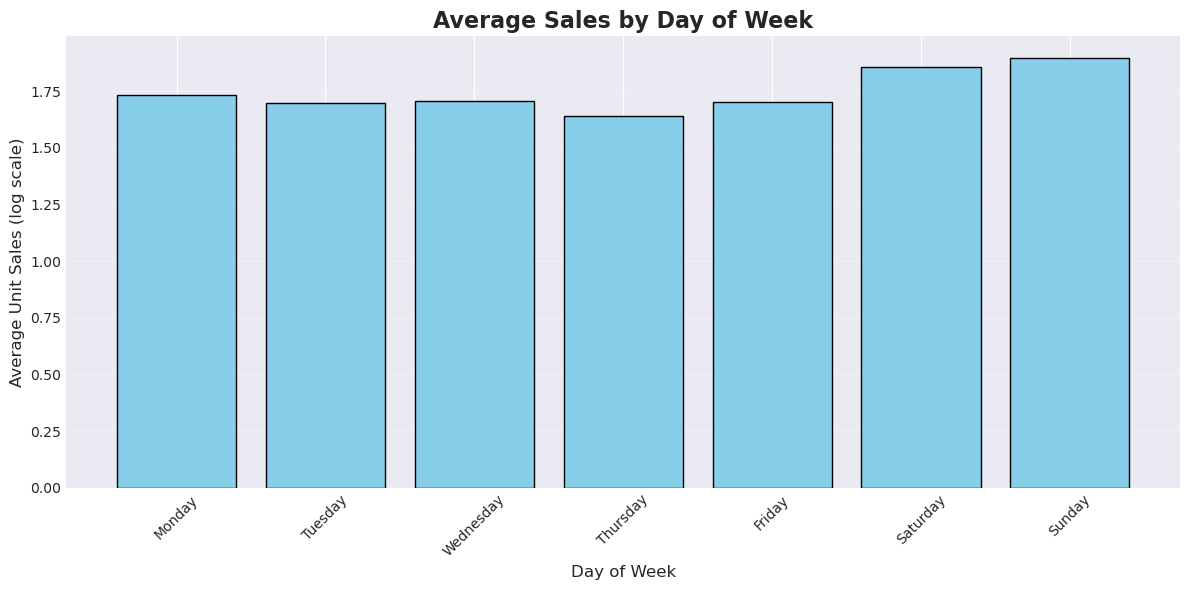


Day of Week Statistics:
day_of_week
0    1.733018
1    1.698118
2    1.706991
3    1.638919
4    1.702519
5    1.856584
6    1.896946
Name: unit_sales, dtype: float64


In [36]:
plt.figure(figsize=(12, 6))

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = df_sample.groupby('day_of_week')['unit_sales'].mean()
plt.bar(range(7), dow_sales.values, color='skyblue', edgecolor='black')
plt.xticks(range(7), day_names, rotation=45)
plt.title('Average Sales by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Unit Sales (log scale)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDay of Week Statistics:")
print(dow_sales)

### Visualization 6: Autocorrelation Plot (Lags 1-30)

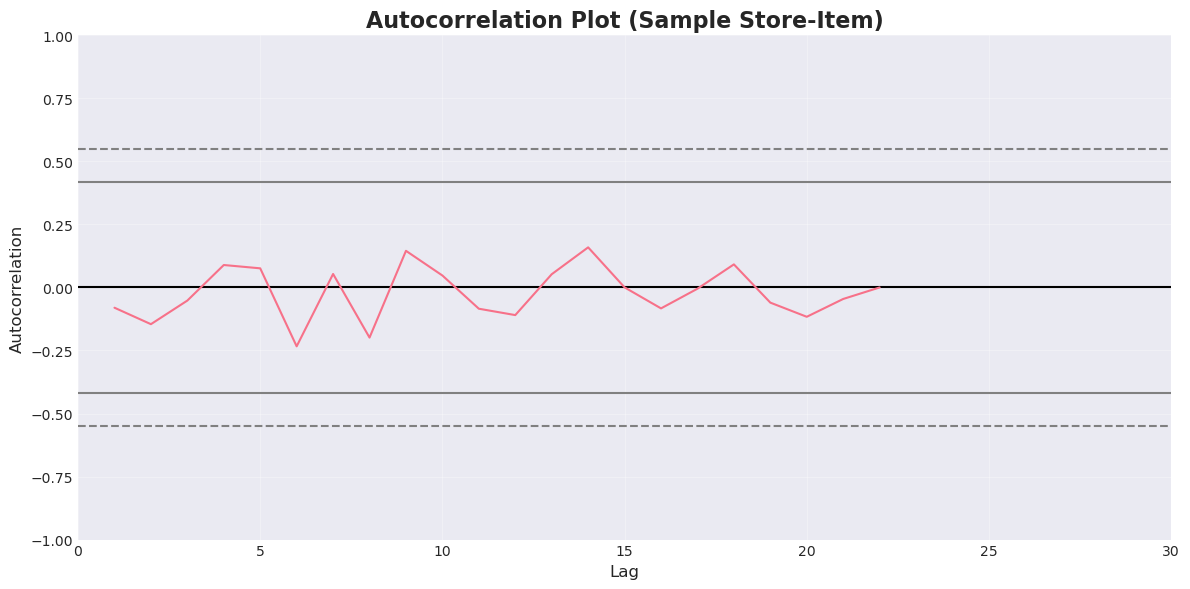

Key lags show strong correlation at 1, 7, 14 days (weekly patterns)


In [37]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 6))

# Sample a single store-item combination for autocorrelation
sample_series = df_sample[(df_sample['store_nbr'] == df_sample['store_nbr'].iloc[0]) & 
                   (df_sample['item_nbr'] == df_sample['item_nbr'].iloc[0])].sort_values('date')['unit_sales']

autocorrelation_plot(sample_series)
plt.title('Autocorrelation Plot (Sample Store-Item)', fontsize=16, fontweight='bold')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlim(0, 30)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key lags show strong correlation at 1, 7, 14 days (weekly patterns)")

### Visualization 7: Rolling Mean Illustration

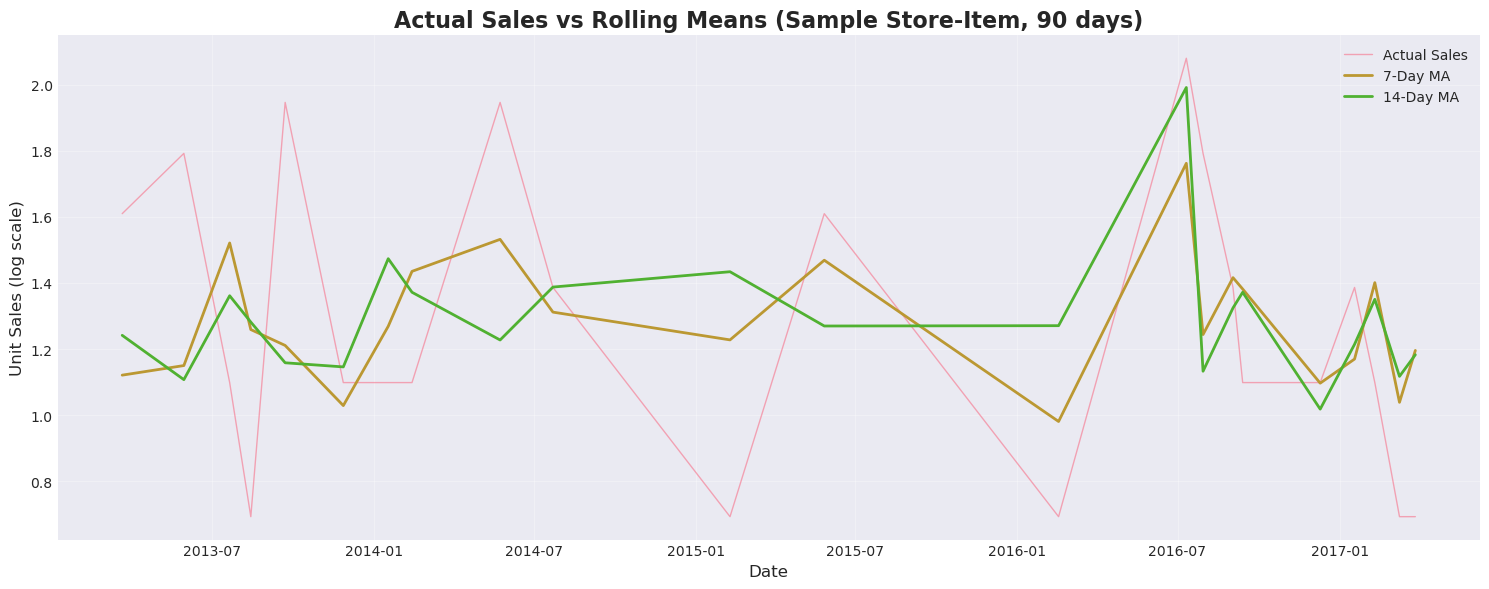

Rolling means smooth out daily volatility and capture trends


In [38]:
plt.figure(figsize=(15, 6))

# Select one store-item for visualization
visualization_df = df_sample[(df_sample['store_nbr'] == df_sample['store_nbr'].iloc[0]) & 
               (df_sample['item_nbr'] == df_sample['item_nbr'].iloc[0])].sort_values('date').head(90)

plt.plot(visualization_df['date'], visualization_df['unit_sales'], label='Actual Sales', alpha=0.6, linewidth=1)
plt.plot(visualization_df['date'], visualization_df['rolling_mean_7'], label='7-Day MA', linewidth=2)
plt.plot(visualization_df['date'], visualization_df['rolling_mean_14'], label='14-Day MA', linewidth=2)

plt.title('Actual Sales vs Rolling Means (Sample Store-Item, 90 days)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales (log scale)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Rolling means smooth out daily volatility and capture trends")

### Visualization 8: Holiday Effect

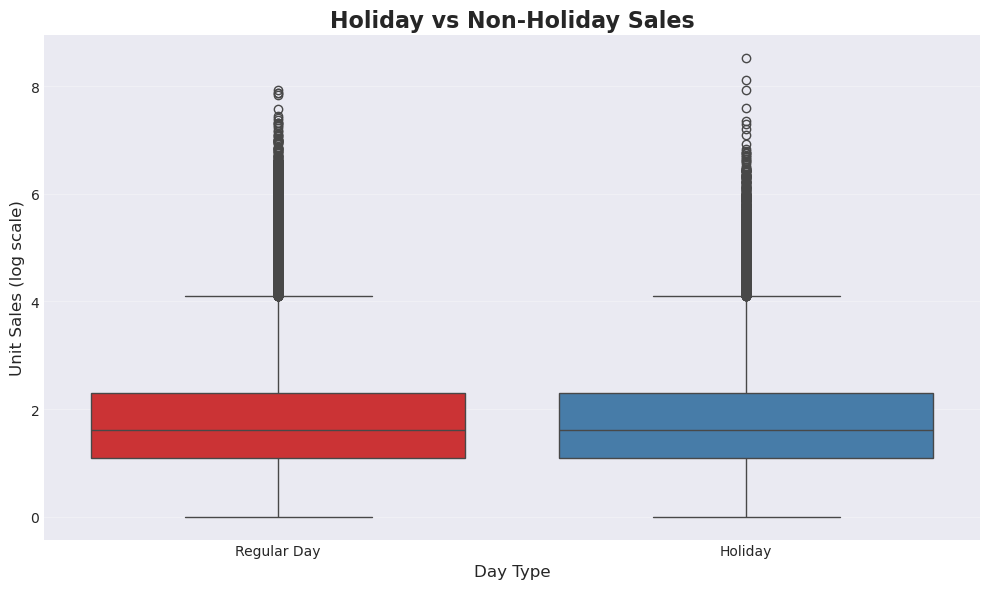


Holiday Statistics:
                mean    median    count
is_holiday                             
0           1.745745  1.609438  1691265
1           1.778123  1.609438   308746


In [39]:
plt.figure(figsize=(10, 6))

df_sample['holiday_status'] = df_sample['is_holiday'].map({0: 'Regular Day', 1: 'Holiday'})
sns.boxplot(data=df_sample, x='holiday_status', y='unit_sales', palette='Set1')
plt.title('Holiday vs Non-Holiday Sales', fontsize=16, fontweight='bold')
plt.xlabel('Day Type', fontsize=12)
plt.ylabel('Unit Sales (log scale)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

holiday_stats = df_sample.groupby('is_holiday')['unit_sales'].agg(['mean', 'median', 'count'])
print("\nHoliday Statistics:")
print(holiday_stats)

### Visualization 9: Perishable vs Non-Perishable Patterns

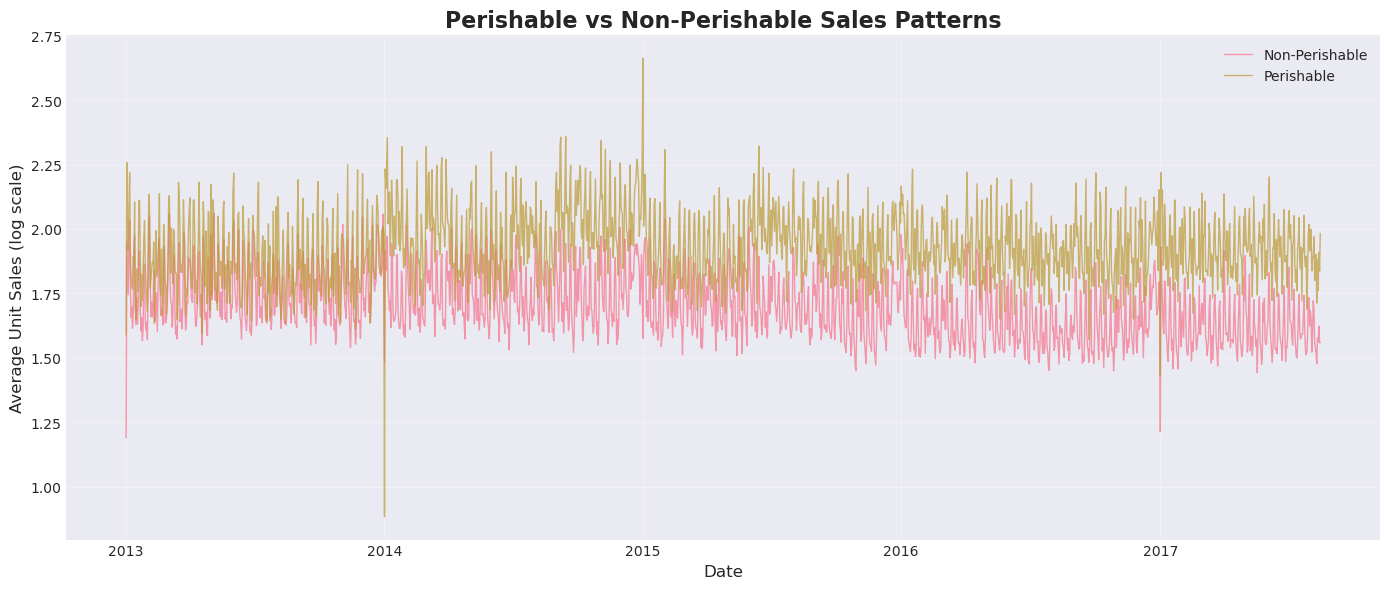


Perishable vs Non-Perishable Statistics:
                mean       std    count
perishable                             
0           1.687641  0.856838  1494774
1           1.937435  0.924895   505237


In [40]:
plt.figure(figsize=(14, 6))

perishable_daily = df_sample.groupby(['date', 'perishable'])['unit_sales'].mean().reset_index()

for p in [0, 1]:
    data = perishable_daily[perishable_daily['perishable'] == p]
    label = 'Non-Perishable' if p == 0 else 'Perishable'
    plt.plot(data['date'], data['unit_sales'], label=label, alpha=0.7, linewidth=1)

plt.title('Perishable vs Non-Perishable Sales Patterns', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Unit Sales (log scale)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

perishable_stats = df_sample.groupby('perishable')['unit_sales'].agg(['mean', 'std', 'count'])
print("\nPerishable vs Non-Perishable Statistics:")
print(perishable_stats)

### Visualization 10: Feature Correlation Heatmap (Top 20 Features)

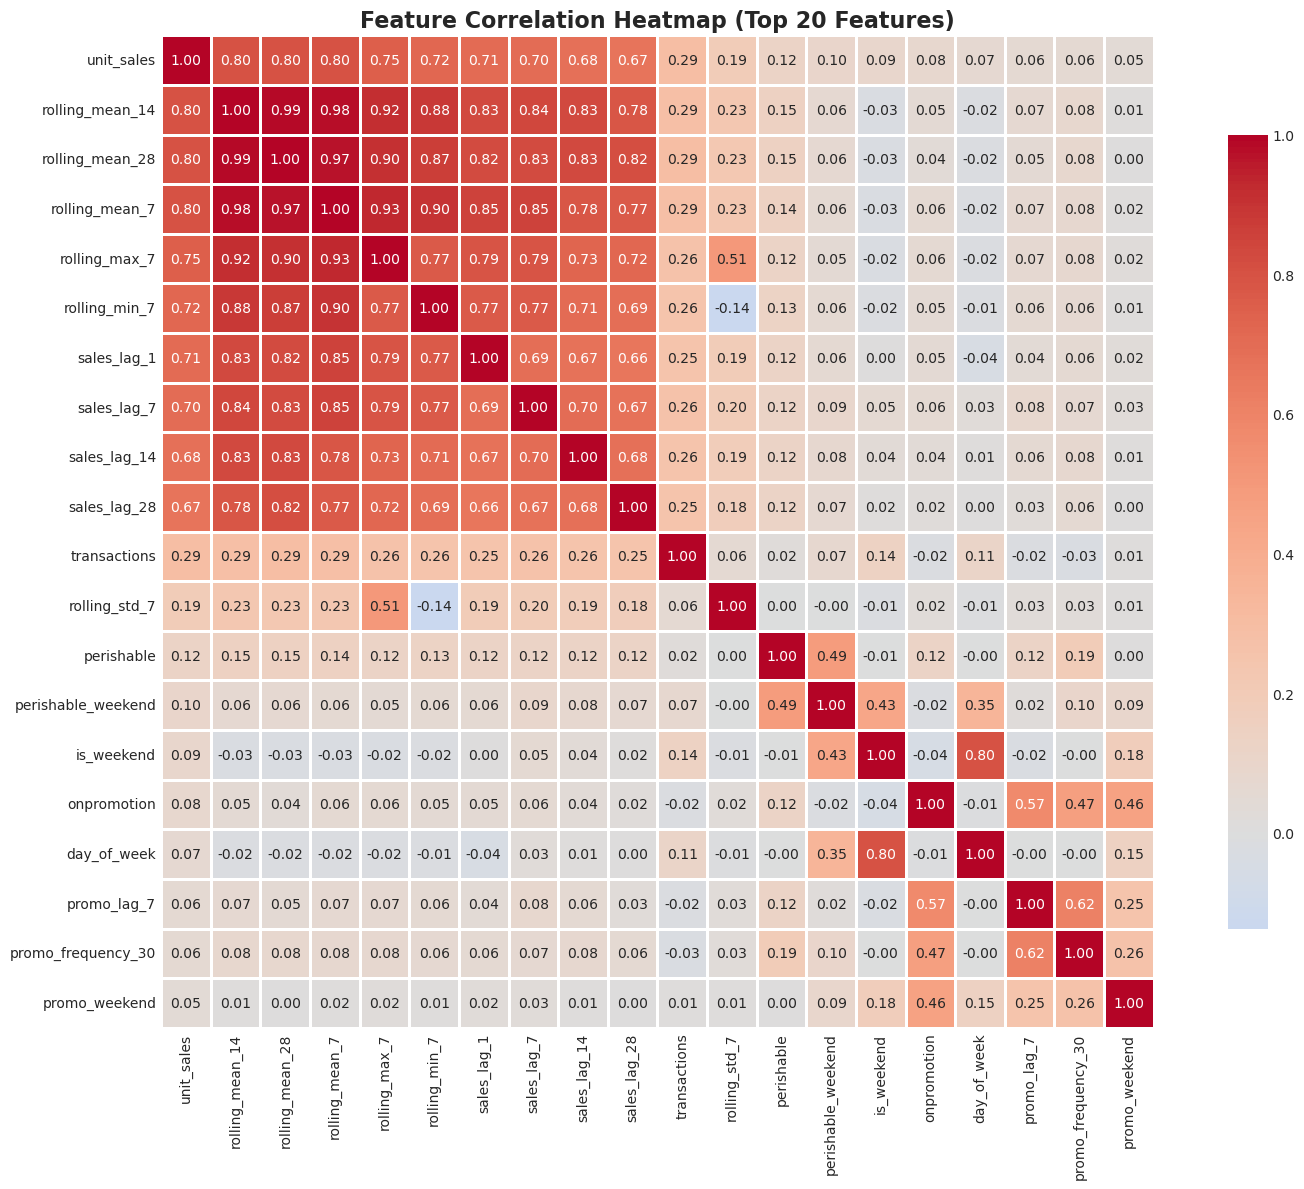


Top 10 Features Correlated with Unit Sales:
unit_sales         1.000000
rolling_mean_14    0.803372
rolling_mean_28    0.802857
rolling_mean_7     0.798183
rolling_max_7      0.747709
rolling_min_7      0.719725
sales_lag_1        0.705682
sales_lag_7        0.699839
sales_lag_14       0.683828
sales_lag_28       0.669071
Name: unit_sales, dtype: float64


In [41]:
plt.figure(figsize=(16, 12))

# Select numeric features for correlation
numeric_features = ['unit_sales'] + all_engineered_features + ['onpromotion', 'perishable', 
                                                                'dcoilwtico', 'transactions']
numeric_features = [f for f in numeric_features if f in df_sample.columns]

# Calculate correlation with unit_sales
correlations = df_sample[numeric_features].corr()['unit_sales'].abs().sort_values(ascending=False)

# Top 20 features
top_20_features = correlations.head(20).index.tolist()
corr_matrix = df_sample[top_20_features].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (Top 20 Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 10 Features Correlated with Unit Sales:")
print(correlations.head(10))

## 7. Train/Test Split (Time-Based on FULL Dataset)

In [42]:
print("="*70)
print("TRAIN/TEST SPLIT ON FULL DATASET")
print("="*70)
print("\nUsing FULL dataset (not sample) for final train/test split")
print(f"Full dataset shape: {df.shape}\n")

# Define split dates
train_end_date = '2017-08-15'
test_start_date = '2017-08-16'
test_end_date = '2017-08-31'

# Split the FULL data
df_train = df[df['date'] <= train_end_date].copy()
df_test = df[(df['date'] >= test_start_date) & (df['date'] <= test_end_date)].copy()

print(f"✓ Train Set: {df_train.shape}")
print(f"  Date range: {df_train['date'].min()} to {df_train['date'].max()}")

print(f"\n✓ Test Set: {df_test.shape}")
print(f"  Date range: {df_test['date'].min()} to {df_test['date'].max()}")

print(f"\nTest set represents {len(df_test) / len(df) * 100:.2f}% of total data")
print(f"Covers {(df_test['date'].max() - df_test['date'].min()).days + 1} days (16 days for forecasting)")

# Save train and test sets
print("\n" + "="*70)
print("SAVING TRAIN/TEST DATASETS")
print("="*70)

train_path = 'results/df_train_final.parquet'
test_path = 'results/df_test_final.parquet'

df_train.to_parquet(train_path, index=False)
df_test.to_parquet(test_path, index=False)

print(f"✓ Training set saved to: {train_path}")
print(f"  Shape: {df_train.shape}")
print(f"  Size: {df_train.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"✓ Test set saved to: {test_path}")
print(f"  Shape: {df_test.shape}")
print(f"  Size: {df_test.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

# Clear memory
del df
print("\n✓ Full dataset cleared from memory")

TRAIN/TEST SPLIT ON FULL DATASET

Using FULL dataset (not sample) for final train/test split
Full dataset shape: (125497040, 41)

✓ Train Set: (125497040, 41)
  Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

✓ Test Set: (0, 41)
  Date range: NaT to NaT

Test set represents 0.00% of total data
Covers nan days (16 days for forecasting)

SAVING TRAIN/TEST DATASETS
✓ Training set saved to: results/df_train_final.parquet
  Shape: (125497040, 41)
  Size: 68.16 GB
✓ Test set saved to: results/df_test_final.parquet
  Shape: (0, 41)
  Size: 0.00 GB

✓ Full dataset cleared from memory


## 8. Final Dataset Summary

In [43]:
print("="*70)
print("FINAL DATASET SUMMARY - READY FOR MODELING")
print("="*70)

print(f"\n📊 Train Dataset: {df_train.shape}")
print(f"📊 Test Dataset: {df_test.shape}")
print(f"Total columns: {len(df_train.columns)}")

print(f"\n📅 Date Range:")
print(f"  Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"  Test: {df_test['date'].min()} to {df_test['date'].max()}")

print(f"\n🏪 Coverage:")
print(f"  Unique stores: {df_train['store_nbr'].nunique()}")
print(f"  Unique items: {df_train['item_nbr'].nunique()}")
print(f"  Product families: {df_train['family'].nunique()}")

print(f"\n🎯 Target Variable:")
print(f"  Name: unit_sales (log-transformed)")
print(f"  Train Mean: {df_train['unit_sales'].mean():.4f}")
print(f"  Train Std: {df_train['unit_sales'].std():.4f}")

print(f"\n🔧 Engineered Features: {len(all_engineered_features)}")
print(f"  Temporal: {len(temporal_features)}")
print(f"  Lag: {len(lag_features)}")
print(f"  Rolling: {len(rolling_features)}")
print(f"  Holiday: {len(holiday_features)}")
print(f"  Promotion: {len(promo_features)}")
print(f"  Interaction: {len(interaction_features)}")

print(f"\n📋 Key Columns:")
print(f"  Base: date, store_nbr, item_nbr, unit_sales")
print(f"  From items: family, class, perishable")
print(f"  From stores: city, state, type, cluster")
print(f"  From oil: dcoilwtico")
print(f"  From transactions: transactions")
print(f"  From holidays: is_holiday, holiday_type, holiday_transferred")
print(f"  Engineered: {len(all_engineered_features)} features")

print("\n" + "="*70)
print("SAVED FILES")
print("="*70)
print("\n📁 Files Created:")
print(f"  1. {train_path}")
print(f"     Training set (2013-01-01 to 2017-08-15)")
print(f"  2. {test_path}")
print(f"     Test set (2017-08-16 to 2017-08-31)")

print("\n✅ Data is ready for XGBoost/LightGBM modeling!")
print("✅ Goal: Predict unit_sales 1-16 days ahead for each (store, item, date)")
print("✅ Metric: RMSLE (Root Mean Squared Logarithmic Error)")
print("\n💡 Memory Optimizations Applied:")
print("   - No intermediate file saves (merged, featured)")
print("   - Removed memory-intensive aggregate features")
print("   - Removed expanding window features")
print("   - Simplified holiday feature calculation")
print("   - Reduced from ~30 to ~18 essential features")
print("="*70)

FINAL DATASET SUMMARY - READY FOR MODELING

📊 Train Dataset: (125497040, 41)
📊 Test Dataset: (0, 41)
Total columns: 41

📅 Date Range:
  Train: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
  Test: NaT to NaT

🏪 Coverage:
  Unique stores: 54
  Unique items: 4036
  Product families: 33

🎯 Target Variable:
  Name: unit_sales (log-transformed)
  Train Mean: 1.7509
  Train Std: 0.8816

🔧 Engineered Features: 25
  Temporal: 8
  Lag: 4
  Rolling: 6
  Holiday: 2
  Promotion: 2
  Interaction: 3

📋 Key Columns:
  Base: date, store_nbr, item_nbr, unit_sales
  From items: family, class, perishable
  From stores: city, state, type, cluster
  From oil: dcoilwtico
  From transactions: transactions
  From holidays: is_holiday, holiday_type, holiday_transferred
  Engineered: 25 features

SAVED FILES

📁 Files Created:
  1. results/df_train_final.parquet
     Training set (2013-01-01 to 2017-08-15)
  2. results/df_test_final.parquet
     Test set (2017-08-16 to 2017-08-31)

✅ Data is ready for XGBoost/Light